In [1]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

plt.style.use('dark_background')

In [2]:
def plot_asset_prices(initial_asset_prices, volatilities, asset_prices_meshgrid,
                       elevation=10, initial_azimuth=230, title=None):

    initial_asset_prices_grid, volatilities_grid = np.meshgrid(initial_asset_prices, volatilities)

    fig, ax = plt.subplots(figsize=(5, 5),
                           subplot_kw={"projection": "3d"})

    surface = ax.plot_surface(initial_asset_prices_grid,
                              volatilities_grid,
                              asset_prices_meshgrid.T,
                              cmap='plasma',
                              linewidth=30, 
                              antialiased=False)

    ax.view_init(elev=elevation, azim=initial_azimuth)

    ax.zaxis.set_rotate_label(False)
    
    ax.set_xlabel('Initial Asset Price')
    ax.set_ylabel('Volatility')
    ax.set_zlabel('Asset Price', rotation=90)
    
    print(title + ':')
    
    plt.show()
    

def plot_asset_price_modes():

    for mode in asset_prices_meshgrid:

        plot_asset_prices(initial_asset_prices, volatilities, asset_prices_meshgrid[mode], title=mode)

In [3]:
def sample_asset_prices(initial_asset_price, time_to_maturity, 
                        risk_free_interest_rate, dividend_rate, 
                        volatility, time_steps_count, samples_count):
    
    rate_difference = risk_free_interest_rate - dividend_rate
    
    samples = np.zeros(samples_count) 
    time_step = time_to_maturity/time_steps_count
    
    weights = np.random.standard_normal(size=(samples_count, time_steps_count))
    
    samples = weights.sum(axis=1) * np.sqrt(time_step)  

    asset_prices = initial_asset_price * np.exp((rate_difference - 0.5 * volatility ** 2) * time_to_maturity 
                                                + volatility * samples) 
    
    # adjusted_asset_prices = asset_prices * np.exp(-risk_free_interest_rate * time_to_maturity)
         
    return asset_prices

In [4]:
def simple_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                       risk_free_interest_rate, dividend_rate, 
                       volatility, option_type, time_steps_count, samples_count):
    
    rate_difference = risk_free_interest_rate - dividend_rate
    
    # Stock prices
    
    samples = np.zeros(samples_count) 
    time_step = time_to_maturity/time_steps_count
    
    weights = np.random.standard_normal(size=(samples_count, time_steps_count))
    
    samples = weights.sum(axis=1) * np.sqrt(time_step)  

    stock_prices = initial_stock_price * np.exp((rate_difference - 0.5 * volatility ** 2) * time_to_maturity 
                                                + volatility * samples)
    
    # Option prices
    
    price_differences = stock_prices - strike_price   
    
    if option_type == 'Put':
        price_differences = -price_differences
    
    price_differences[price_differences < 0] = 0
    
    option_prices = price_differences * np.exp(-risk_free_interest_rate * time_to_maturity)
         
    return option_prices

In [5]:
# Fixed

T = time_to_maturity = 180 / 365
n = time_steps_count = 300

q = dividend_rate = 0.3
r = risk_free_interest_rate = 0.4

CallPut = option_type = 'Call'

### 9) Alex Dataset - 1 Initial Price, 1 Volatility - 1000 Bins - 10M Samples

In [9]:
DATASET_FILE = 'simulated_prices/23_dataset.csv'

initial_asset_prices = [15]
volatilities = [0.7]

samples_count = 1000000
histogram_bins_count = 100000

In [10]:
np.savetxt(DATASET_FILE, [],
           header='initial_asset_price,volatility,asset_price,probability',
           comments='')

asset_prices_shape = len(initial_asset_prices), len(volatilities)

asset_prices_meshgrid = defaultdict(lambda: np.zeros(asset_prices_shape))

simulation_tracker = tqdm.tqdm(
    initial_asset_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1
)

for i, initial_asset_price in enumerate(simulation_tracker):

    for j, volatility in enumerate(volatilities):

        asset_prices = sample_asset_prices(
            initial_asset_price=initial_asset_price, 
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility,
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
               
        # Meshgrid

        asset_prices_meshgrid['Mean asset prices'][i, j] = asset_prices.mean()
        asset_prices_meshgrid['Minimum asset prices'][i, j] = asset_prices.min()
        asset_prices_meshgrid['Maximum asset prices'][i, j] = asset_prices.max()
        
        
        # Histogram

        samples_per_bin, bin_edges = np.histogram(asset_prices, bins=histogram_bins_count)

        bin_width = bin_edges[1] - bin_edges[0]

        asset_price_bins = bin_centers = bin_edges[:-1] + bin_width / 2

        probabilities = samples_per_bin / samples_count
        

        # Batches

        initial_asset_price_batch = np.full(histogram_bins_count, initial_asset_price)

        volatility_batch = np.full(histogram_bins_count, volatility)

        sample_batch = np.vstack((initial_asset_price_batch,
                                  volatility_batch,
                                  asset_price_bins,
                                  probabilities)).T

        with open(DATASET_FILE, 'ab') as dataset_file:
            np.savetxt(dataset_file, sample_batch, fmt=('%d', '%f', '%f', '%f'), delimiter=',')

Simulating: 100%|███████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.20s/simulation]


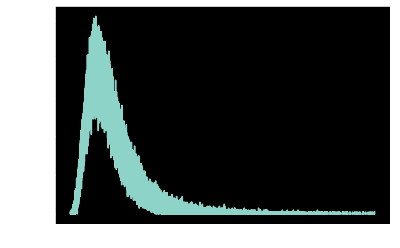

In [11]:
plt.plot(probabilities);

### 8) Assets - No Probabilities - Mean - 10 Initial prices, 10 Volatilities - 1M Samples

In [6]:
DATASET_FILE = 'simulated_prices/assets_no_probabilities_1M_samples.csv'

initial_asset_prices = np.linspace(15, 300, 10)
volatilities = np.linspace(0.0, 1.0, 10)

samples_count = 1000000

In [7]:
np.savetxt(DATASET_FILE, [],
           header='initial_asset_price,volatility,asset_price,probability',
           comments='')

asset_prices_shape = len(initial_asset_prices), len(volatilities)

asset_prices_meshgrid = defaultdict(lambda: np.zeros(asset_prices_shape))

simulation_tracker = tqdm.tqdm(
    initial_asset_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1
)

for i, initial_asset_price in enumerate(simulation_tracker):

    for j, volatility in enumerate(volatilities):

        asset_prices = sample_asset_prices(
            initial_asset_price=initial_asset_price, 
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility,
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
               
        # Meshgrid
        
        mean_asset_price = asset_prices.mean()

        asset_prices_meshgrid['Mean asset prices'][i, j] = mean_asset_price
        asset_prices_meshgrid['Minimum asset prices'][i, j] = asset_prices.min()
        asset_prices_meshgrid['Maximum asset prices'][i, j] = asset_prices.max()        

        # Row
        
        row = [[initial_asset_price, volatility, mean_asset_price, 1]]

        with open(DATASET_FILE, 'ab') as dataset_file:
            np.savetxt(dataset_file, row, fmt=('%d', '%f', '%f', '%f'), delimiter=',')

Simulating: 100%|█████████████████████████████████████████████████████| 10/10 [09:19<00:00, 55.95s/simulation]


### 7) Assets - 100K Samples - 100 Bins - 10K Dataset

In [13]:
DATASET_FILE = 'simulated_prices/asset_prices_double_initial_price_10_bins.csv'

# initial_asset_prices = np.linspace(15, 300, 10)
volatilities = np.linspace(0.1, 0.5, 10)

initial_asset_prices = [150]

samples_count = 100000

histogram_bins_count = 10

In [14]:
np.savetxt(DATASET_FILE, [],
           header='initial_asset_price,volatility,asset_price,probability',
           comments='')

asset_prices_shape = len(initial_asset_prices), len(volatilities)

asset_prices_meshgrid = defaultdict(lambda: np.zeros(asset_prices_shape))

simulation_tracker = tqdm.tqdm(
    initial_asset_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1
)

for i, initial_asset_price in enumerate(simulation_tracker):

    for j, volatility in enumerate(volatilities):

        asset_prices = sample_asset_prices(
            initial_asset_price=initial_asset_price, 
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility,
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
               
        # Meshgrid

        asset_prices_meshgrid['Mean asset prices'][i, j] = asset_prices.mean()
        asset_prices_meshgrid['Minimum asset prices'][i, j] = asset_prices.min()
        asset_prices_meshgrid['Maximum asset prices'][i, j] = asset_prices.max()
        
        
        # Histogram

        samples_per_bin, bin_edges = np.histogram(asset_prices, bins=histogram_bins_count)

        bin_width = bin_edges[1] - bin_edges[0]

        asset_price_bins = bin_centers = bin_edges[:-1] + bin_width / 2

        probabilities = samples_per_bin / samples_count
        

        # Batches

        initial_asset_price_batch = np.full(histogram_bins_count, initial_asset_price)

        volatility_batch = np.full(histogram_bins_count, volatility)

        sample_batch = np.vstack((initial_asset_price_batch,
                                  volatility_batch,
                                  asset_price_bins,
                                  probabilities)).T

        with open(DATASET_FILE, 'ab') as dataset_file:
            np.savetxt(dataset_file, sample_batch, fmt=('%d', '%f', '%f', '%f'), delimiter=',')

Simulating: 100%|███████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.22s/simulation]


Mean asset prices:


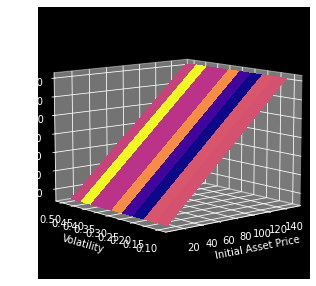

Minimum asset prices:


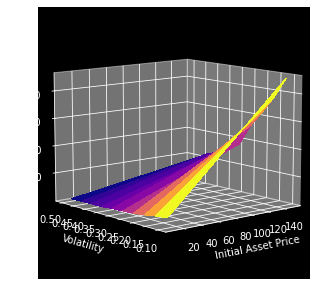

Maximum asset prices:


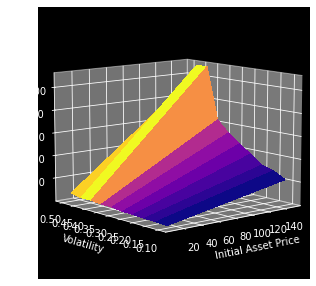

In [12]:
plot_asset_price_modes()

### 6) Asset Prices

In [29]:
DATASET_FILE = 'simulated_prices/asset_prices.csv'

# initial_stock_prices = np.linspace(0, 1000, 11)
# volatilities = np.linspace(0, 1.0, 11)

initial_stock_prices = [500]
volatilities = [0.0, 0.2, 0.4, 0.6]

samples_count = 1000000

histogram_bins_count = samples_count
top_bins_count = 1000

time_steps_count = 300
strike_price = 100

volatilities

[0.0, 0.2, 0.4, 0.6]

In [ ]:
np.savetxt(DATASET_FILE, [],
           header='initial_stock_price,volatility,option_price,probability',
           comments='')

option_prices_shape = len(initial_stock_prices), len(volatilities)

option_prices_meshgrid = defaultdict(lambda: np.zeros(option_prices_shape))

figure, rows = plt.subplots(3, len(volatilities),
                            figsize=(20, 12), 
                            # sharex='col'
                           )

columns = list(zip(*rows))

simulation_tracker = tqdm.tqdm(
    initial_stock_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1
)

for i, initial_stock_price in enumerate(simulation_tracker):

    for j, volatility in enumerate(volatilities):
        
        print(volatility)

        option_prices = simple_monte_carlo(
            initial_stock_price=initial_stock_price, 
            strike_price=strike_price,
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility, 
            option_type=option_type, 
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )

        asset_prices = sample_asset_prices(
            initial_asset_price=initial_stock_price, 
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility,
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
        
        # Option price derivation
        
        price_differences = asset_prices - strike_price   
    
        if option_type == 'Put':
            price_differences = -price_differences
    
        price_differences[price_differences < 0] = 0

        derivated_option_prices = price_differences * np.exp(-risk_free_interest_rate 
                                                             * time_to_maturity)
        
        # Meshgrid
        
        option_prices_meshgrid['Minimum option prices'][i, j] = option_prices.min()
        option_prices_meshgrid['Maximum option prices'][i, j] = option_prices.max()
        
        
        # Histogram

        samples_per_bin, bin_edges = np.histogram(option_prices, bins=histogram_bins_count)

        bin_width = bin_edges[1] - bin_edges[0]

        option_price_bins = bin_centers = bin_edges[:-1] + bin_width / 2

        probabilities = samples_per_bin / samples_count
        
        
        # Top bins
        
        pairs = np.vstack((option_price_bins, probabilities)).T
                
        descending_indices = np.argsort(pairs[:, 1])[::-1]
        
        sorted_pairs = pairs[descending_indices]
        
        top_sorted_pairs = sorted_pairs[:top_bins_count]
        
        top_option_prices = top_sorted_pairs[:, 0]
        top_probabilities = top_sorted_pairs[:, 1]
       
        option_prices_meshgrid['Most probable option prices'][i, j] = top_option_prices[0]
        option_prices_meshgrid['Most probable option price means'][i, j] = top_option_prices.mean()
        option_prices_meshgrid['Most probable option price weighted means'][i, j] = (top_option_prices * 
                                                                                     top_probabilities).mean()
        
        # Plot
        
        assets_ax, derivated_options_ax, options_ax = columns[j]
        
        assets_ax.hist(asset_prices,
                       bins=samples_count,
                       histtype='step', 
                       label=f"Volatility: {volatility}");

        assets_ax.set_xlabel("Asset price")
        assets_ax.set_ylabel("Samples count")
        assets_ax.legend()
        
        derivated_options_ax.hist(derivated_option_prices,
                                  bins=samples_count,
                                  histtype='step', 
                                  label=f"Volatility: {volatility}");

        derivated_options_ax.set_xlabel("Derivated option price")
        derivated_options_ax.set_ylabel("Samples count")
        derivated_options_ax.legend()
        
        options_ax.hist(option_prices,
                        bins=samples_count,
                        histtype='step', 
                        label=f"Volatility: {volatility}");

        options_ax.set_xlabel("Option price")
        options_ax.set_ylabel("Samples count")
        options_ax.legend()
        
        

        
        # plt.show() 
        
        # # Printouts
    
        # print("top_option_prices[0]:", top_option_prices[0])
        # print("top_option_prices.mean():", top_option_prices.mean())
        
        # print("bin_centers:\n", bin_centers)        
        # print("samples_per_bin:\n", samples_per_bin, samples_per_bin.sum())
        # print("probabilities:\n", probabilities, probabilities.sum())
        # print("pairs:\n", pairs)
        # print("descending_indices:\n", descending_indices.shape)        
        # print("sorted_pairs:\n", sorted_pairs)
        # print("top_sorted_pairs:\n", top_sorted_pairs)
        
        # print("top_option_prices:", top_option_prices)
        # print("top_probabilities:", top_probabilities)
        

        # Batches

        initial_stock_price_batch = np.full(top_bins_count, initial_stock_price)

        volatility_batch = np.full(top_bins_count, volatility)

        sample_batch = np.vstack((initial_stock_price_batch,
                                  volatility_batch,
                                  top_option_prices,
                                  top_probabilities)).T

        with open(DATASET_FILE, 'ab') as dataset_file:
            np.savetxt(dataset_file, sample_batch, fmt=('%d', '%f', '%f', '%f'), delimiter=',')

Simulating:   0%|                                                               | 0/1 [00:00<?, ?simulation/s]

0.0


In [ ]:
# # Histogram

# plt.hist(top_option_prices,
#          bins=top_bins_count,
#          # density=True,
#          histtype='step', 
#          label=f"{samples_count} samples");

# plt.xlabel("Option price")
# plt.ylabel("Samples")
# plt.legend();

In [10]:
# plot_option_price_modes()